<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparations" data-toc-modified-id="Preparations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparations</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Models" data-toc-modified-id="Models-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#Loading-Pretrained" data-toc-modified-id="Loading-Pretrained-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Loading Pretrained</a></span></li></ul></li><li><span><a href="#Quantitative" data-toc-modified-id="Quantitative-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Quantitative</a></span></li><li><span><a href="#Qualitative" data-toc-modified-id="Qualitative-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Qualitative</a></span><ul class="toc-item"><li><span><a href="#One-Shot-Pred" data-toc-modified-id="One-Shot-Pred-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>One Shot Pred</a></span></li></ul></li><li><span><a href="#Autoregressive" data-toc-modified-id="Autoregressive-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Autoregressive</a></span></li></ul></div>

# ICML - Unet Results

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Preparations

In [2]:
cd ..

/private/home/yannd/projects/Neural-Process-Family


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset 

In [4]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

In [5]:
svhn_train, svhn_test = get_dataset("svhn")(split="train"), get_dataset("svhn")(split="test")
mnist_train, mnist_test = get_dataset("mnist")(split="train"), get_dataset("mnist")(split="test")
cifar10_train, cifar10_test = get_dataset("cifar10")(split="train", is_augment=True), get_dataset("cifar10")(split="test", is_augment=True)

# celeba64 not fully trained yet
train_datasets = {"mnist":mnist_train, "svhn":svhn_train, "cifar10":cifar10_train}
test_datasets = {"mnist":mnist_test, "svhn":svhn_test, "cifar10":cifar10_test}

data_names = {
             "mnist":"MNIST",
            "svhn":"SVHN",
            "cifar10":"CIFAR10"
             }

Using downloaded and verified file: /private/home/yannd/projects/Neural-Process-Family/utils/data/../../data/train_32x32.mat
Using downloaded and verified file: /private/home/yannd/projects/Neural-Process-Family/utils/data/../../data/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


In [6]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
                                      target_masker=no_masker,
                                      is_add_cntxts_to_trgts=False)

In [7]:
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

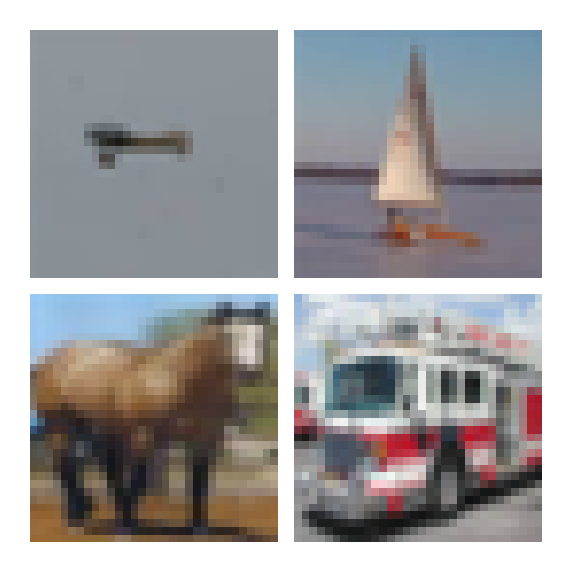

In [8]:
plot_dataset_samples_imgs(cifar10_test, figsize=(9,5))

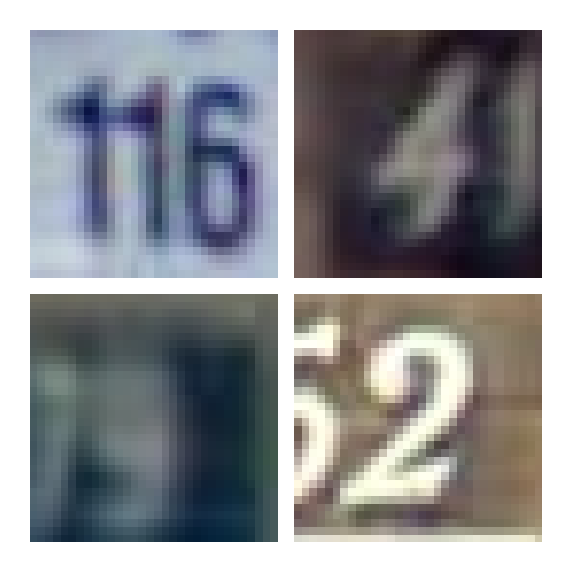

In [9]:
plot_dataset_samples_imgs(svhn_test, figsize=(9,5))

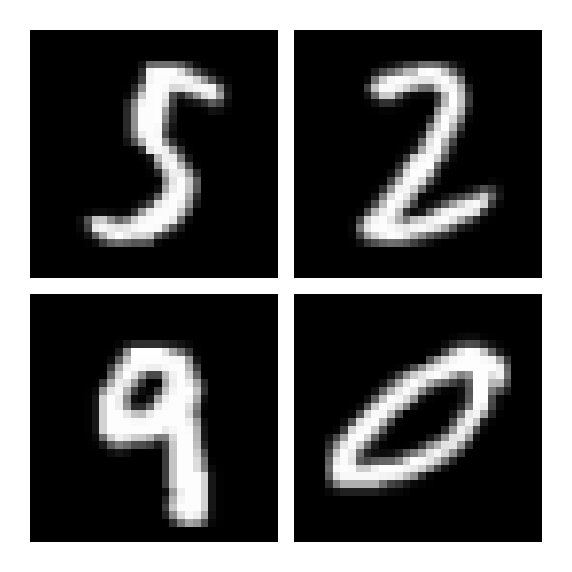

In [10]:
plot_dataset_samples_imgs(mnist_test, figsize=(9,5))

### Models

In [11]:
X_DIM = 2  # 2D spatial input 

In [12]:
from functools import partial
from neuralproc import RegularGridsConvolutionalProcess, AttentiveNeuralProcess, NeuralProcessLoss, ConvolutionalProcess
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock
from neuralproc import merge_flat_input

In [13]:
from train_imgs import get_model

# models that take into account the grid
models_grided = {}

models_grided["GridedCCPUnetShared_large"] = get_model("GridedCCPUnetShared", n_blocks=7, r_dim=256)
models_grided["GridedCCPUnet_large"] = get_model("GridedCCPUnet", n_blocks=7, r_dim=256)#--n-blocks
models_grided["GridedCCPUnetShared_small"] = get_model("GridedCCPUnetShared", n_blocks=5, r_dim=64)
models_grided["GridedCCPUnet_small"] = get_model("GridedCCPUnet", n_blocks=5, r_dim=64)#--n-blocks

In [14]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

In [15]:
from utils.helpers import count_parameters
    
for k,v in models_grided.items():
    print(k, "- N Param:", count_parameters(v(y_dim=3)))

GridedCCPUnetShared_large - N Param: 660287
GridedCCPUnet_large - N Param: 660287
GridedCCPUnetShared_small - N Param: 78335
GridedCCPUnet_small - N Param: 78335


/private/home/yannd/projects/Neural-Process-Family/neuralproc/predefined/mlp.py:63: UserWarning: hidden_size=64 larger than output=6 and input=32. Setting it to 32.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### Loading Pretrained

In [16]:
folder = "results/icml/"

In [17]:
def merge_dicts(dicts):
    out = dict()
    for d in dicts:
        out.update(d)
    return out

In [18]:
from neuralproc import NeuralProcessLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch

import os
import contextlib

kwargs = dict(chckpnt_dirname=folder ,
             is_retrain=False, 
             train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
             patience=10,
             batch_size=16,
             seed=123,
             runs=1)

#train_datasets = {k:v  for k,v in train_datasets.items() if k!= "cifar10"}

# Takes 1-3 mins
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f): # don't print
    trainers_grided = train_models(train_datasets, 
                                 add_y_dim(models_grided, train_datasets),
                                  NeuralProcessLoss,
                                  iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                           is_return_masks=True), 
                                 iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                           is_return_masks=True),
                                 **kwargs) 

/private/home/yannd/projects/Neural-Process-Family/neuralproc/predefined/mlp.py:63: UserWarning: hidden_size=64 larger than output=2 and input=32. Setting it to 32.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


# Conditional Posterior Comparison

## Quantitative

In [19]:
from utils.helpers import load_all_results

In [20]:
results=load_all_results(folder).groupby(["Data", "Model"]).agg(["count","mean","std"]).reset_index()

In [31]:
results.pivot_table(values="LogLike", index="Model", columns="Data")["mean"].dropna()

Data,cifar10,mnist,svhn
Model,,,
GridedCCPUnetShared_large,3.167044,1.223789,3.941680
GridedCCPUnetShared_small,3.120367,1.199073,3.904457
GridedCCPUnet_large,3.201020,1.233970,3.942968
GridedCCPUnet_small,3.156568,1.211276,3.913290


In [32]:
results.pivot_table(values="LogLike", index="Model", columns="Data")["std"].dropna()

Data,cifar10,mnist,svhn
Model,,,
GridedCCPUnetShared_large,0.026799,0.007664,0.010309
GridedCCPUnetShared_small,0.025523,0.008939,0.015367
GridedCCPUnet_large,0.034049,0.008480,0.015928
GridedCCPUnet_small,0.025547,0.007512,0.013615


## Qualitative

In [23]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE, points_to_grid

### One Shot Pred

In [24]:
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde

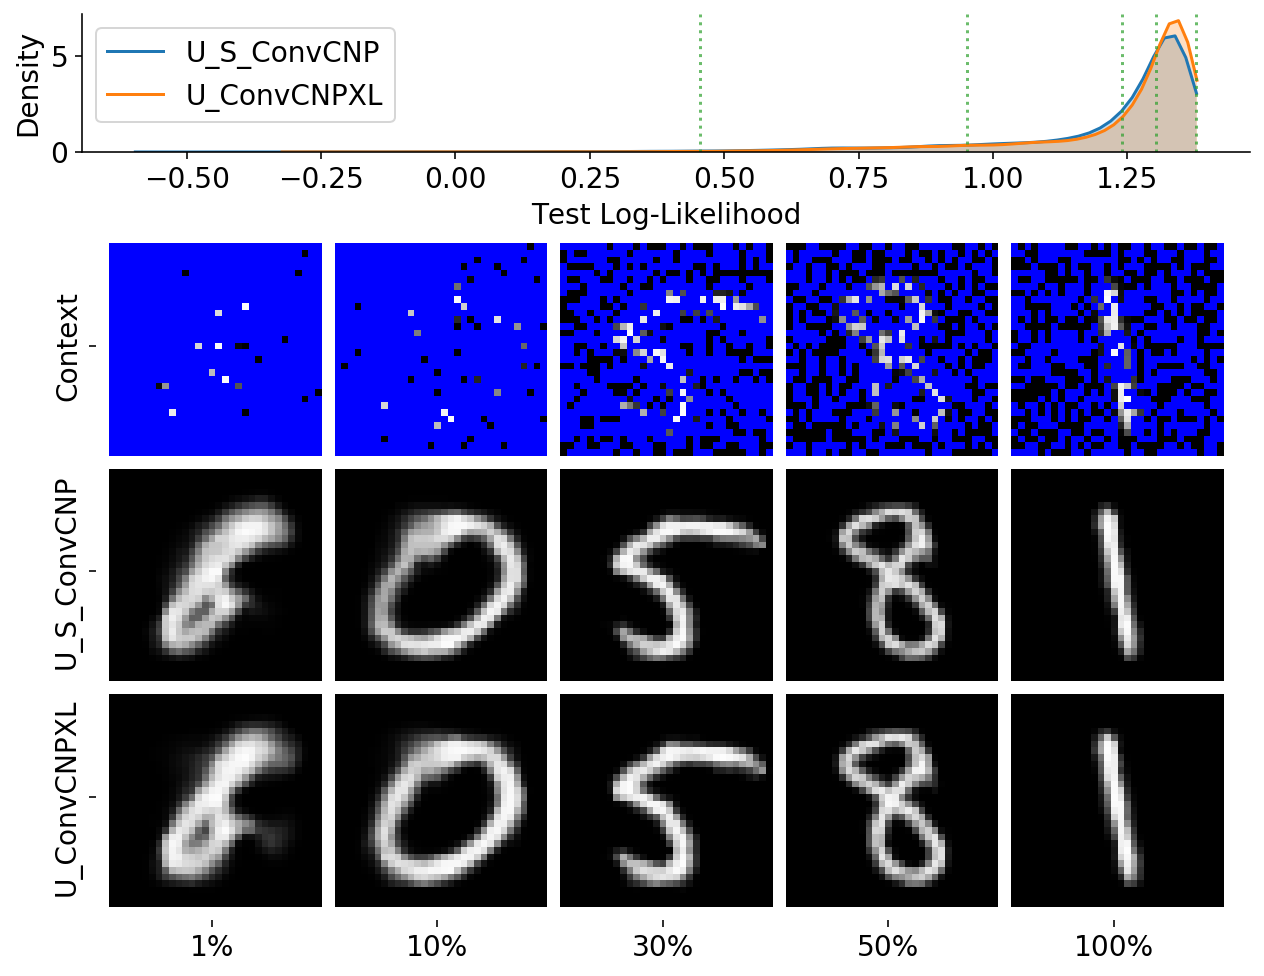

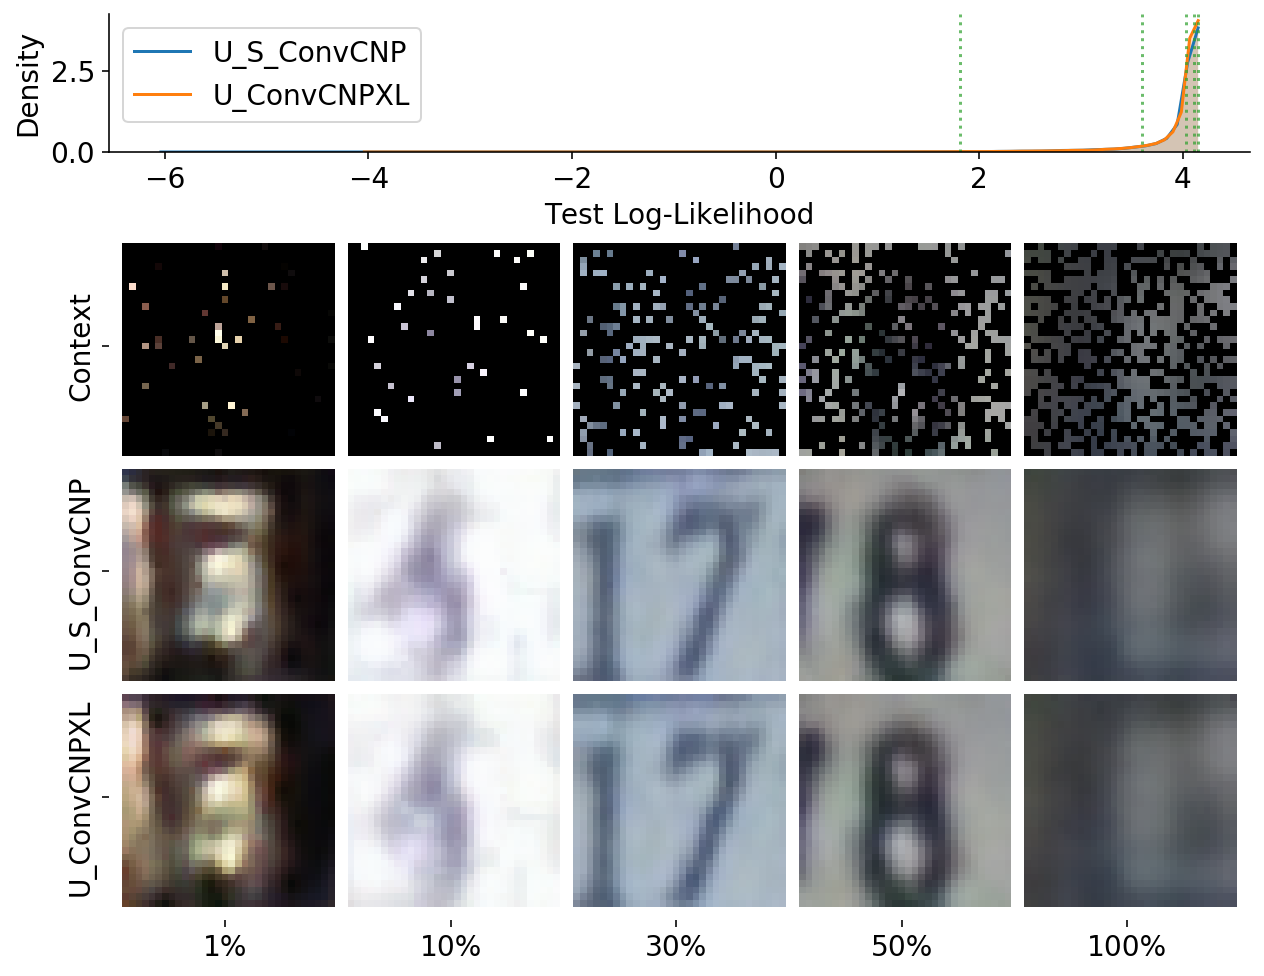

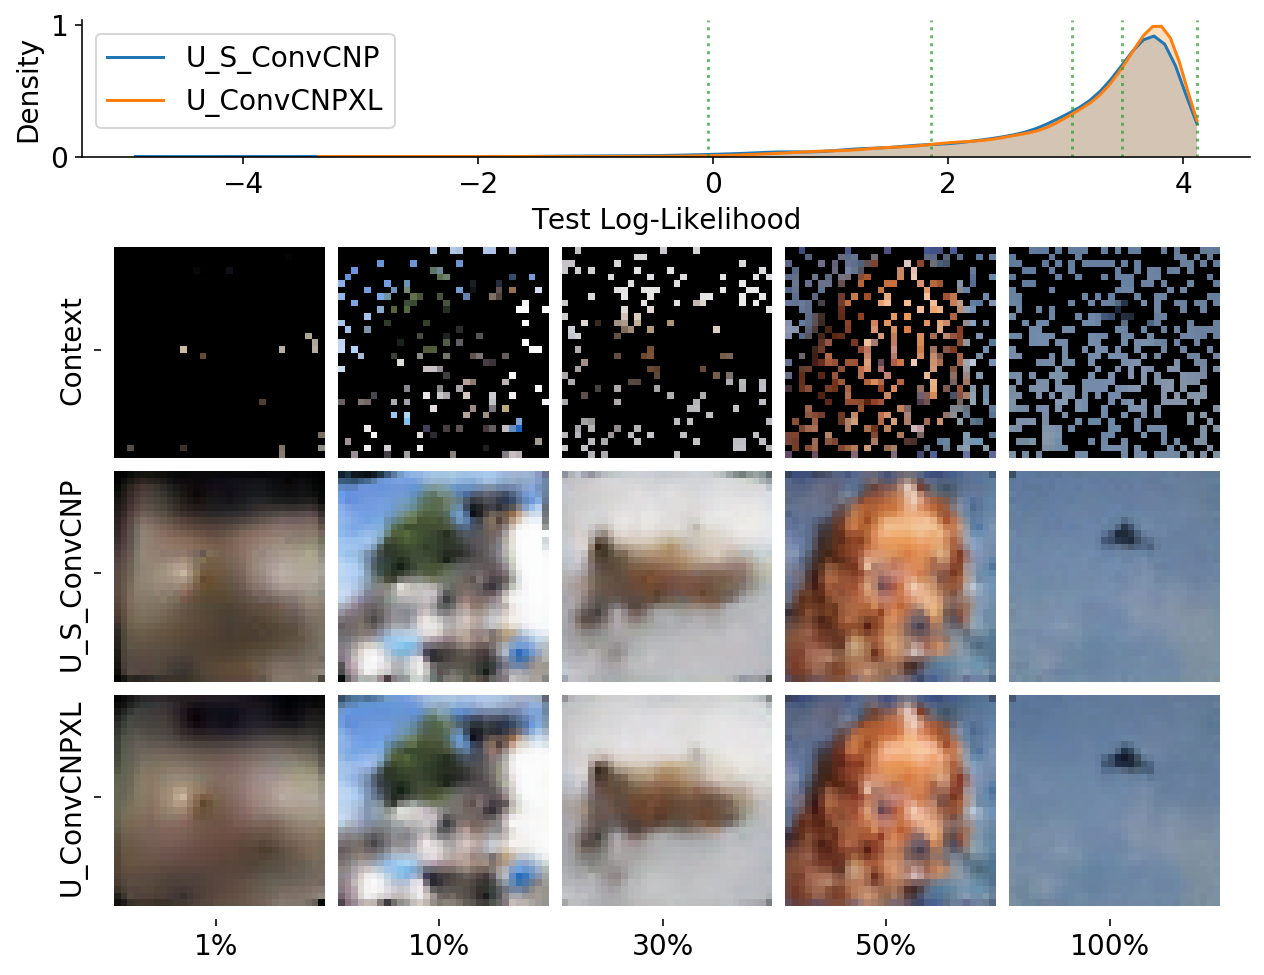

In [35]:
for data_name, test_data in test_datasets.items():
    for sffx in ["large"]:
        test_loglike = plot_qualitative_with_kde(["U_S_ConvCNP", trainers_grided['{}/GridedCCPUnetShared_{}/run_0'.format(data_name,sffx)]],
                                                 test_data,
                                                 named_trainer_compare=["U_ConvCNPXL", trainers_grided['{}/GridedCCPUnet_{}/run_0'.format(data_name,sffx)]],
                                                 figsize=(9, 7),
                                                 percentiles=[1,10,30,50,100],
                                                height_ratios=[1,5],
                                                 #x_lim={"left":0.5, "right":4.5},
                                                 h_pad=0)

## Autoregressive

In [26]:
class GenNextAutoregressivePixelL1:
    """Generates the next autoregressive pixels by using the ones at `d` L1
    distance from context points.
    """

    def __init__(self, d):
        self.d = d

    def __call__(self, mask_cntxt):
        """
        Given the current context mask, return the next
        temporary target mask by setting all pixels than are at d manhattan distance
        of a context pixel.
        """
        next_mask_cntxt = mask_cntxt.clone()
        slcs = [slice(None)] * (len(mask_cntxt.shape))

        while not (next_mask_cntxt == 1).all():
            for _ in range(self.d):
                # shift array to the 4 directions to get all neighbors
                right, left, up, down = self.get_shifted_masks(next_mask_cntxt)
                next_mask_cntxt = right | left | up | down | next_mask_cntxt
            yield next_mask_cntxt.clone()

    def get_shifted_masks(self, mask):
        """Given a batch of masks , returns the same masks shifted to the right,
        left, up, down."""
        mask = mask.float()
        right_shifted = torch.cat((mask[:, :, -1:, ...] * 0, mask[:, :, :-1, ...]), dim=2)
        left_shifted = torch.cat((mask[:, :, 1:, ...], mask[:, :, :1, ...] * 0), dim=2)
        up_shifted = torch.cat((mask[:, 1:, :, ...], mask[:, :1, :, ...] * 0), dim=1)
        down_shifted = torch.cat((mask[:, -1:, :, ...] * 0, mask[:, :-1, :, ...]), dim=1)
        return right_shifted.bool(), left_shifted.bool(), up_shifted.bool(), down_shifted.bool()

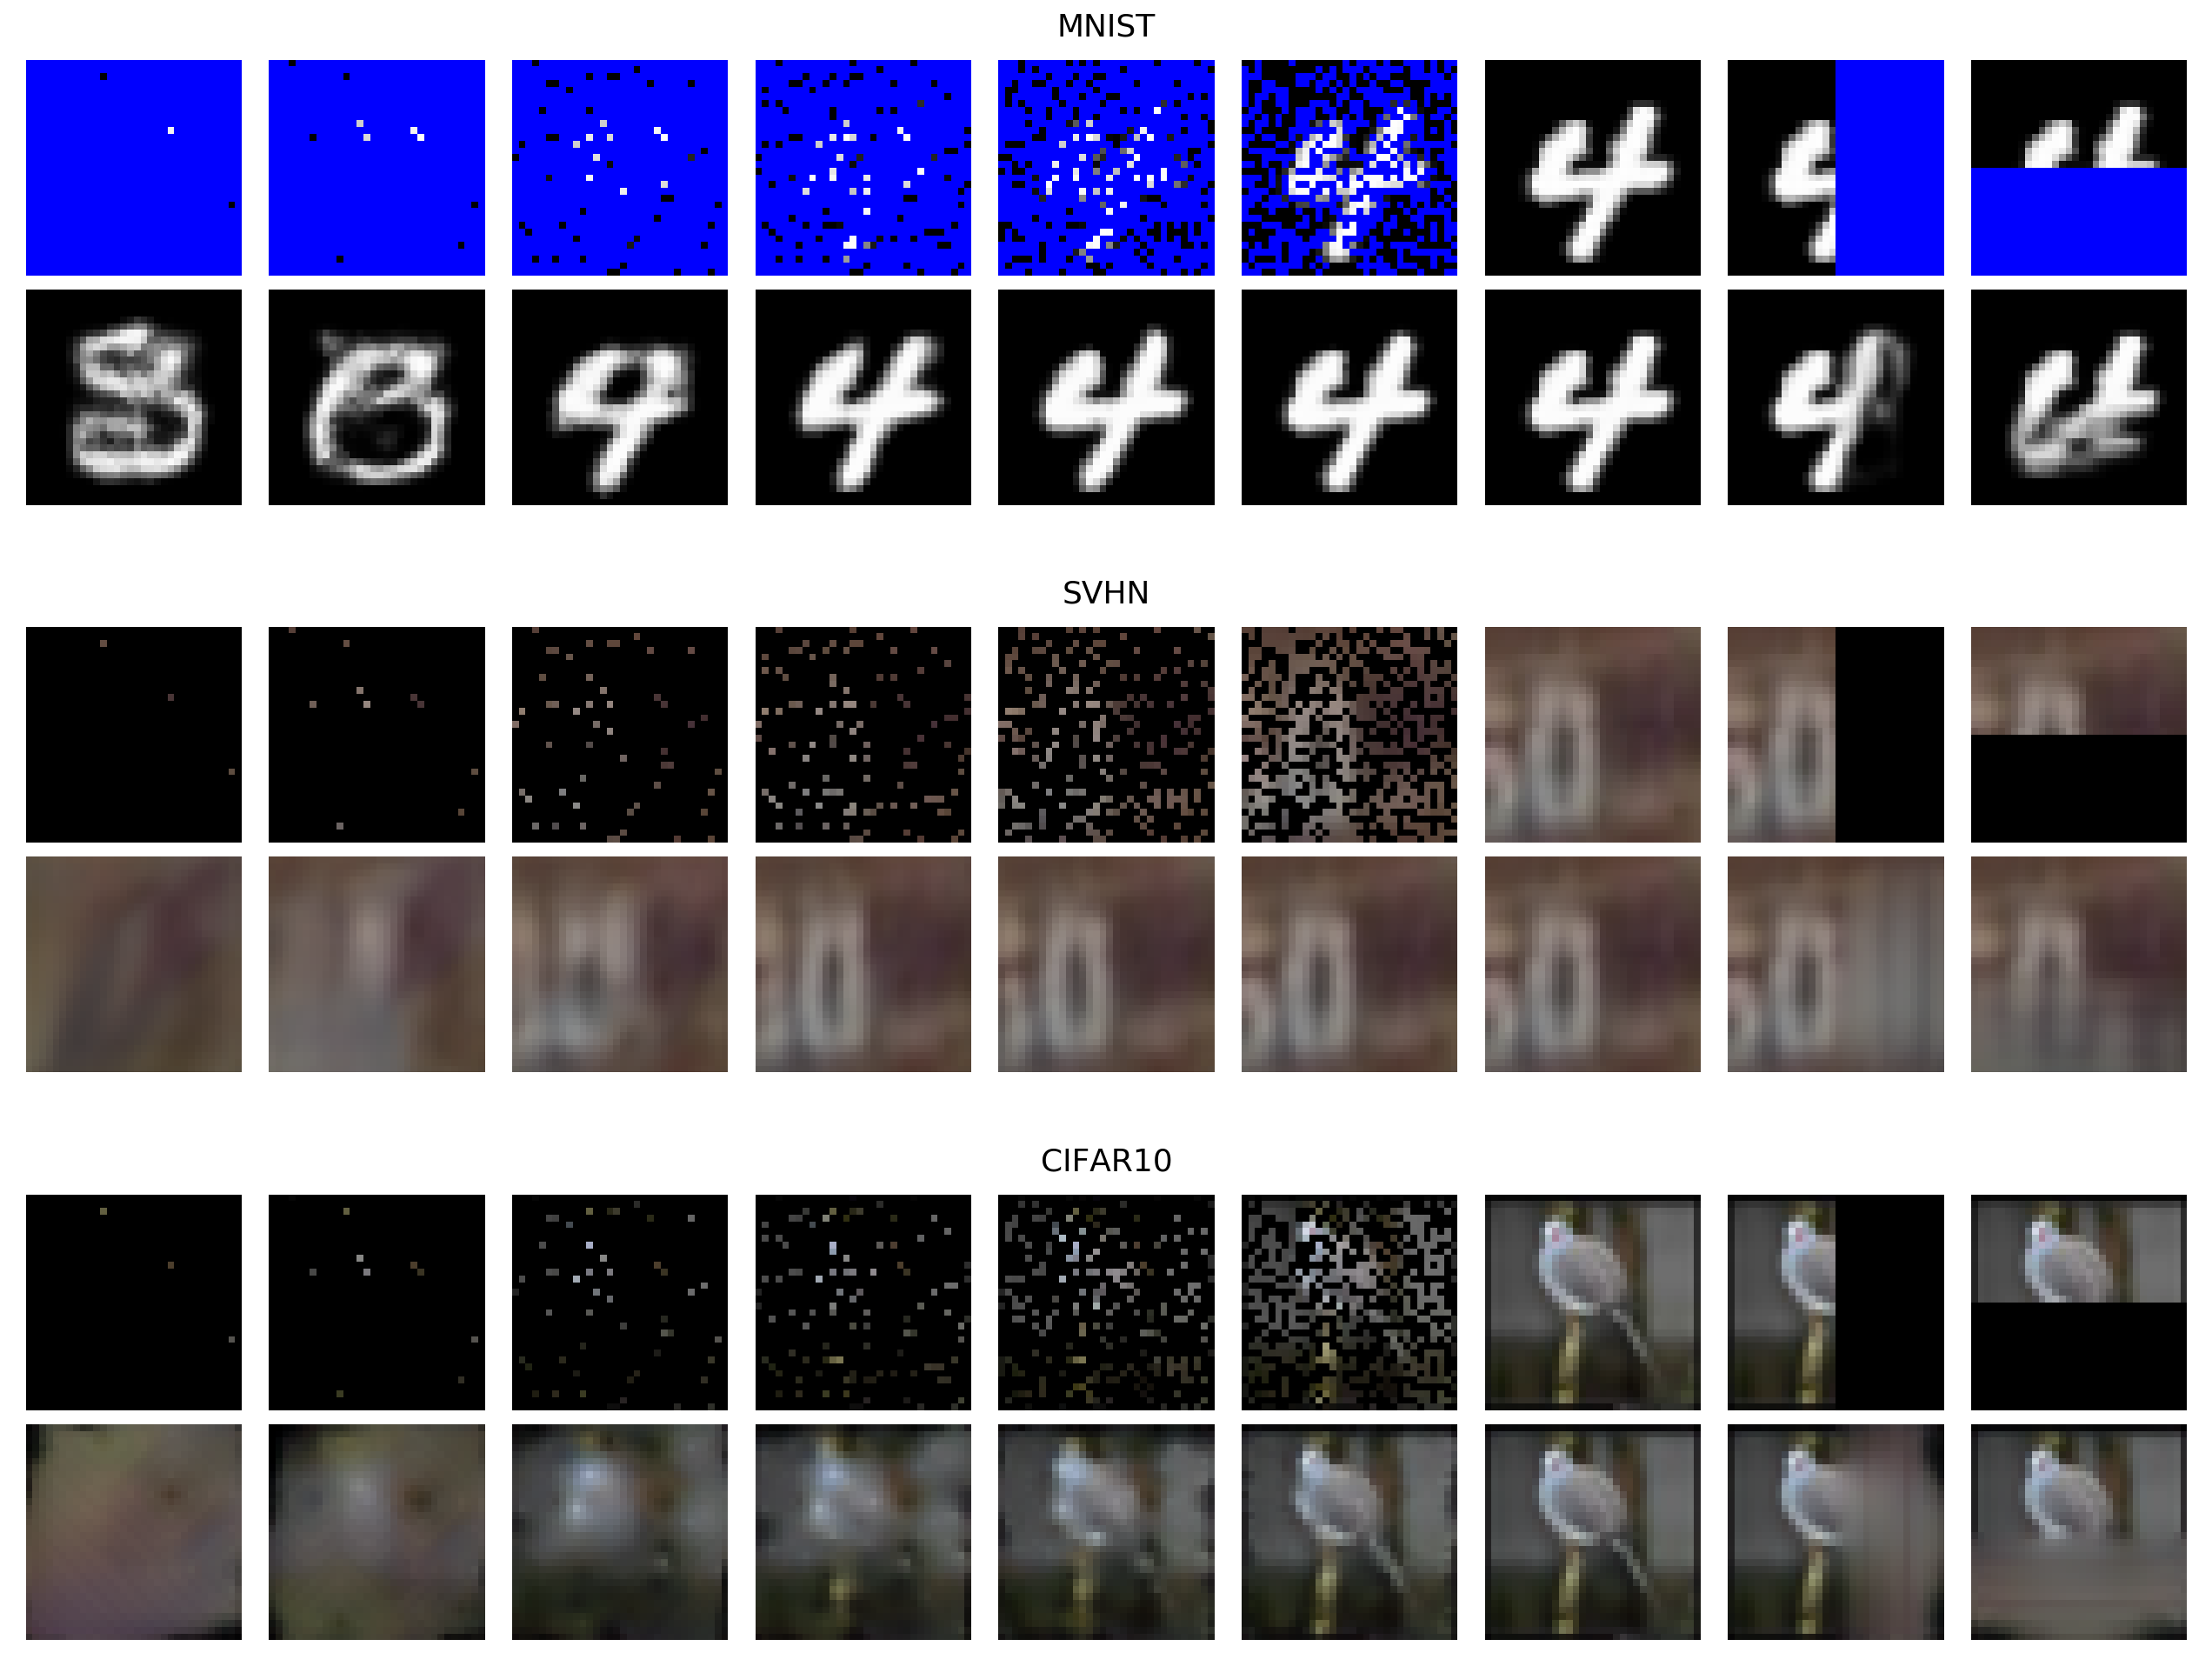

In [37]:
#from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor, GenNextAutoregressivePixelL1
import time

context_maskers = [RandomMasker(min_nnz=3, max_nnz=3),
                   RandomMasker(min_nnz=0.01, max_nnz=0.01),
                   RandomMasker(min_nnz=0.05, max_nnz=0.05),
                   RandomMasker(min_nnz=0.1, max_nnz=0.1),
                   RandomMasker(min_nnz=0.2, max_nnz=0.2),
                   RandomMasker(min_nnz=0.5, max_nnz=0.5),
                   no_masker, # 100%
                   partial(half_masker, dim=1),
                   partial(half_masker, dim=0),
                  ]

def plot_all(data_models):
    fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

    for i,(data_test, model) in enumerate(data_models):
        grid = torch.cat([plot_posterior_img(data_test, 
                                          GridCntxtTrgtGetter(context_masker=c,
                                                             target_masker=no_masker), 
                                          trainers_grided['{}_large/run_0'.format(model)].module_.cpu(), 
                                          MeanPredictor=partial(AutoregressivePredictor,
                                                                gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                                          n_plots=1,
                                          is_uniform_grid=True,
                                          is_return=True,
                                          seed=12) # don't  show same images for celeba32 and celeba64
            for c in context_maskers], dim=2)

        axes[i].imshow(grid.permute(1, 2, 0).numpy())
        axes[i].axis("off")
        axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)

        
data_models = [(mnist_test, "mnist/GridedCCPUnet"),
               (svhn_test, f"svhn/GridedCCPUnet"),
               (cifar10_test, f"cifar10/GridedCCPUnet"),
              ]

plot_all(data_models)
    

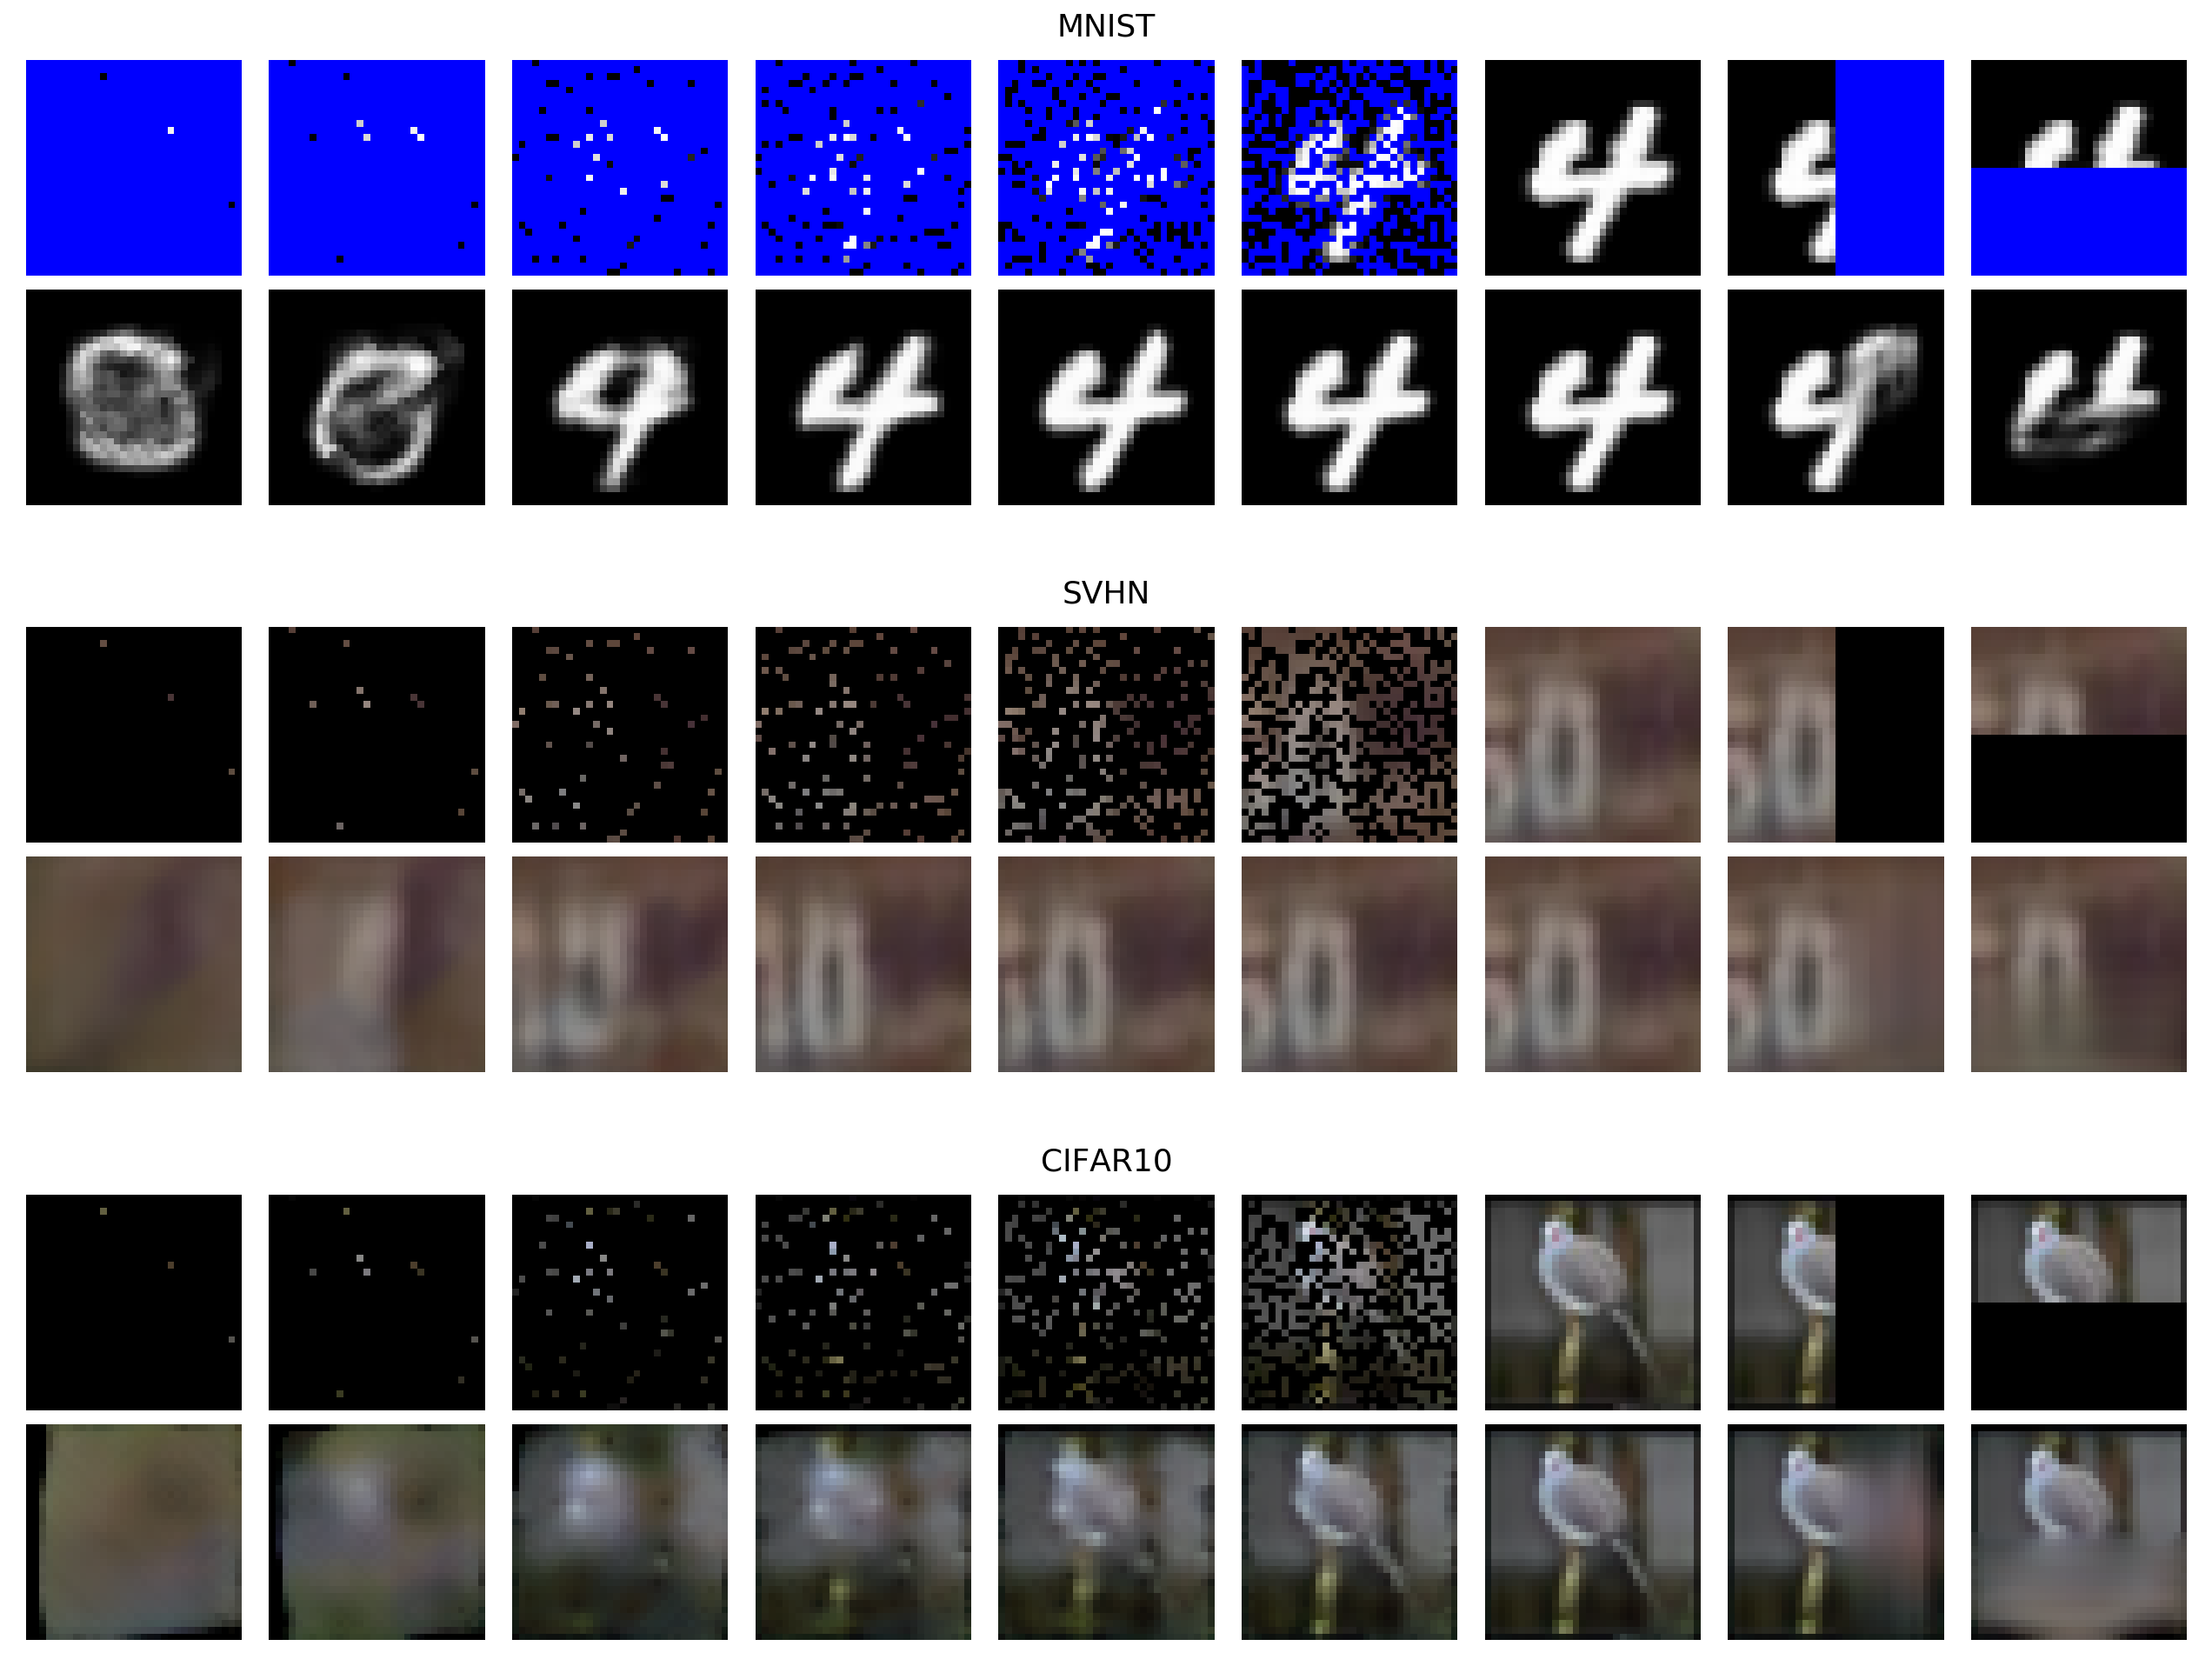

In [38]:
data_models = [(mnist_test, "mnist/GridedCCPUnetShared"),
               (svhn_test, f"svhn/GridedCCPUnetShared"),
               (cifar10_test, f"cifar10/GridedCCPUnetShared"),
              ]

plot_all(data_models)

# Representation Difference

In [50]:
import os
import glob 
raw_files = glob.glob(os.path.join(folder,"**","mlp_score.csv"), recursive=True)

In [96]:
import pandas as pd

def get_score(raw_file):
    with open(raw_file, "r") as f:
        out = f.read().replace("mlp,","\n").replace("100,","").replace("1000,","").replace("10000,","").replace("-1,","")
        out = [float(el) for el in out.split("\n")[1:]]
    return out

dfs = pd.DataFrame([[col for i, col in enumerate(f.split("/")[2:-1])] + get_score(f)
              for f in raw_files], 
             columns=["data","model","run","100","1000","10000","-1"]).apply(pd.to_numeric, errors="ignore")

In [100]:
dfs.groupby(["model","data"]).mean()

100      1000     10000        -1
model                     data                                           
GridedCCPUnetShared_large cifar10  0.155910  0.217720  0.311725  0.392095
                          mnist    0.549870  0.771045  0.845735  0.844705
                          svhn     0.154663  0.225079  0.343627  0.376058
GridedCCPUnetShared_small cifar10  0.157475  0.245615  0.320500  0.350395
                          mnist    0.389435  0.509280  0.645705  0.599890
                          svhn     0.121326  0.169007  0.216146  0.236426
GridedCCPUnet_large       cifar10  0.151965  0.207875  0.311200  0.378550
                          mnist    0.543245  0.779160  0.847225  0.845565
                          svhn     0.149389  0.215389  0.318299  0.357846
GridedCCPUnet_small       cifar10  0.165525  0.253700  0.330305  0.357975
                          mnist    0.367495  0.468985  0.620145  0.578910
                          svhn     0.121164  0.167753  0.225250  0.245089

In [101]:
dfs.groupby(["model","data"]).std()

100      1000     10000        -1
model                     data                                           
GridedCCPUnetShared_large cifar10  0.023370  0.020079  0.018176  0.011331
                          mnist    0.023791  0.012314  0.010172  0.014151
                          svhn     0.013679  0.012184  0.012601  0.012106
GridedCCPUnetShared_small cifar10  0.018268  0.017218  0.010958  0.005900
                          mnist    0.023056  0.037269  0.023720  0.023794
                          svhn     0.008192  0.012522  0.015174  0.015099
GridedCCPUnet_large       cifar10  0.024540  0.023232  0.018880  0.013043
                          mnist    0.026717  0.016839  0.014381  0.015984
                          svhn     0.017051  0.015875  0.020654  0.020220
GridedCCPUnet_small       cifar10  0.023349  0.017160  0.009672  0.010463
                          mnist    0.033539  0.055526  0.035576  0.041181
                          svhn     0.009580  0.011958  0.016393  0.011980

In [102]:
dfs.groupby(["model","data"]).count()

run  100  1000  10000  -1
model                     data                              
GridedCCPUnetShared_large cifar10   20   20    20     20  20
                          mnist     20   20    20     20  20
                          svhn      20   20    20     20  20
GridedCCPUnetShared_small cifar10   20   20    20     20  20
                          mnist     20   20    20     20  20
                          svhn      20   20    20     20  20
GridedCCPUnet_large       cifar10   20   20    20     20  20
                          mnist     20   20    20     20  20
                          svhn      20   20    20     20  20
GridedCCPUnet_small       cifar10   20   20    20     20  20
                          mnist     20   20    20     20  20
                          svhn      20   20    20     20  20